# PDE-Net求解对流扩散方程

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/data_mechanism_fusion/mindspore_pde_net.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/data_mechanism_fusion/mindspore_pde_net.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_zh_cn/data_mechanism_fusion/pde_net.ipynb)

## 概述

PDE-Net是Zichao Long等人提出的一种前馈深度网络用于从数据中学习偏微分方程，同时实现了准确预测复杂系统的动力学特性和揭示潜在的PDE模型。PDE-Net的基本思想是通过学习卷积核(滤波器)来逼近微分算子，并应用神经网络或其他机器学习方法来拟合未知的非线性响应。数值实验表明，即使在噪声环境中，该模型也可以识别被观测的动力学方程，并预测相对较长时间的动态行为。更多信息可参考[PDE-Net: Learning PDEs from Data](https://arxiv.org/abs/1710.09668).

本案例要求**MindSpore版本 >= 2.0.0**以调用如下接口: *mindspore.jit, mindspore.jit_class, mindspore.data_sink*。

## 问题描述

本案例求解可变参数的对流-扩散偏微分方程的反问题，并实现长期预测。

## 控制方程

在本研究中，对流扩散方程的形式为：

$$
u_t = a(x,y) u_x + b(x,y) u_y + c u_{xx} + d u_{yy}, \quad (x,y) \in[0,2 \pi] \times[0,2 \pi]
$$

$$
u|_{t=0} = u_0(x,y)
$$

各项导数的系数分别为：

$$
a(x,y)=0.5(cos(y)+x(2\pi-x)sin(x))+0.6 \quad
b(x,y)=2(cos(y)+sin(x))+0.8
$$

$$
c=0.2 \quad
d=0.3
$$


## PDE-Net的模型结构

PDE-Net由多个$\delta T$ Block串联构成，以实现长序列信息的预测，在每一个$\delta T$ Block中，包含可训练参数的moment矩阵，该矩阵可根据映射关系转化为对应导数的卷积核，从而获取物理场的导数。将导数及其对应物理量经线性组合后，采用前向欧拉法，即可推导下一个时间步的信息。

![Pdenet1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindflow/docs/source_zh_cn/data_mechanism_fusion/images/pdenet-1.jpg)

![Pdenet2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindflow/docs/source_zh_cn/data_mechanism_fusion/images/pdenet-2.jpg)

## 技术路径

MindSpore Flow求解该问题的具体流程如下：

1. 构建模型。
2. 单步训练。
3. 多步训练。
4. 模型推理及可视化。

In [1]:
import os
import time
import numpy as np

import mindspore
from mindspore import set_seed
from mindspore import nn, Tensor, ops, jit, load_param_into_net

下述`src`可以在[applications/data_mechanism_fusion/pde_net/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/data_mechanism_fusion/pde_net/src)下载。

In [2]:
from mindflow.cell import PDENet
from mindflow.utils import load_yaml_config
from mindflow.loss import get_loss_metric, RelativeRMSELoss
from mindflow.pde import UnsteadyFlowWithLoss

from src import init_model, create_dataset, calculate_lp_loss_error
from src import make_dir, scheduler, get_param_dic
from src import plot_coe, plot_extrapolation_error, get_label_coe, plot_test_error

所有配置参数可以在[configuration file](https://gitee.com/mindspore/mindscience/blob/r0.7/MindFlow/applications/data_mechanism_fusion/pde_net/configs/pde_net.yaml)修改。

In [3]:
set_seed(0)
np.random.seed(0)
mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="GPU", device_id=3)

In [4]:
# load configuration yaml
config = load_yaml_config('pde_net.yaml')

## 构建模型

MindSpore Flow提供了`PDENet`接口可以直接建立PDENet模型，需指定网格的宽度、高度、数据深度、边界条件、拟合的最高阶数等信息。

In [5]:
def init_model(config):
    return PDENet(height=config["mesh_size"],
                  width=config["mesh_size"],
                  channels=config["channels"],
                  kernel_size=config["kernel_size"],
                  max_order=config["max_order"],
                  dx=2 * np.pi / config["mesh_size"],
                  dy=2 * np.pi / config["mesh_size"],
                  dt=config["dt"],
                  periodic=config["perodic_padding"],
                  enable_moment=config["enable_moment"],
                  if_fronzen=config["if_frozen"],
                  )

## 单步训练

由于每个$\delta T$ Block的参数是共享的，因此模型根据$\delta T$ Block的串联个数依次增加，逐一进行训练。其中，在step为1时，模型处于warm-up阶段，PDE-Net的moment为“frozen”状态，此时moment中的参数不参与训练。每新增一个$\delta T$ Block，程序先进行数据生成和数据集的读取，初始化模型后，需载入前一个step训练的checkpoint，并定义优化器、模式、loss函数，并进行模型训练，在训练中模型会实时反映模型性能。

In [6]:
def train_single_step(step, config, lr, train_dataset, eval_dataset):
    """train PDE-Net with advancing steps"""

    print("Current step for train loop: {}".format(step, ))
    model = init_model(config)

    epoch = config["epochs"]
    warm_up_epoch_scale = 10
    if step == 1:
        model.if_fronzen = True
        epoch = warm_up_epoch_scale * epoch
    elif step == 2:
        param_dict = get_param_dic(config["summary_dir"], step - 1, epoch * 10)
        load_param_into_net(model, param_dict)
        print("Load pre-trained model successfully")
    else:
        param_dict = get_param_dic(config["summary_dir"], step - 1, epoch)
        load_param_into_net(model, param_dict)
        print("Load pre-trained model successfully")

    optimizer = nn.Adam(model.trainable_params(), learning_rate=Tensor(lr))
    problem = UnsteadyFlowWithLoss(model, t_out=step, loss_fn=RelativeRMSELoss(), data_format="NTCHW")

    def forward_fn(u0, uT):
        loss = problem.get_loss(u0, uT)
        return loss

    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(u0, uT):
        loss, grads = grad_fn(u0, uT)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    steps = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)

    for cur_epoch in range(epoch):
        local_time_beg = time.time()
        model.set_train()

        for _ in range(steps):
            cur_loss = sink_process()
            print("epoch: %s, loss is %s" % (cur_epoch + 1, cur_loss), flush=True)
        local_time_end = time.time()
        epoch_seconds = (local_time_end - local_time_beg) * 1000
        step_seconds = epoch_seconds / steps
        print("Train epoch time: {:5.3f} ms, per step time: {:5.3f} ms".format
              (epoch_seconds, step_seconds), flush=True)

        if (cur_epoch + 1) % config["save_epoch_interval"] == 0:
            ckpt_file_name = "ckpt/step_{}".format(step)
            ckpt_dir = os.path.join(config["summary_dir"], ckpt_file_name)
            if not os.path.exists(ckpt_dir):
                make_dir(ckpt_dir)
            ckpt_name = "pdenet-{}.ckpt".format(cur_epoch + 1, )
            mindspore.save_checkpoint(model, os.path.join(ckpt_dir, ckpt_name))

        if (cur_epoch + 1) % config['eval_interval'] == 0:
            calculate_lp_loss_error(problem, eval_dataset, config["batch_size"])

## 多步训练

PDE-Net是逐步进行训练。
使用**MindSpore>= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [7]:
def train(config):
    lr = config["lr"]
    for i in range(1, config["multi_step"] + 1):
        db_name = "train_step{}.mindrecord".format(i)
        dataset = create_dataset(config, i, db_name, "train", data_size=2 * config["batch_size"])
        train_dataset, eval_dataset = dataset.create_train_dataset()
        lr = scheduler(int(config["multi_step"] / config["learning_rate_reduce_times"]), step=i, lr=lr)
        train_single_step(step=i, config=config, lr=lr, train_dataset=train_dataset, eval_dataset=eval_dataset)


In [8]:
if not os.path.exists(config["mindrecord_data_dir"]):
    make_dir(config["mindrecord_data_dir"])
train(config)

Mindrecorder saved
Current step for train loop: 1
epoch: 1, loss is 313.45258
Train epoch time: 7294.444 ms, per step time: 7294.444 ms
epoch: 2, loss is 283.09055
Train epoch time: 15.857 ms, per step time: 15.857 ms
epoch: 3, loss is 292.2815
Train epoch time: 16.684 ms, per step time: 16.684 ms
epoch: 4, loss is 300.3354
Train epoch time: 18.559 ms, per step time: 18.559 ms
epoch: 5, loss is 295.53436
Train epoch time: 16.430 ms, per step time: 16.430 ms
epoch: 6, loss is 289.45068
Train epoch time: 8.752 ms, per step time: 8.752 ms
epoch: 7, loss is 297.86658
Train epoch time: 10.015 ms, per step time: 10.015 ms
epoch: 8, loss is 269.71762
Train epoch time: 9.050 ms, per step time: 9.050 ms
epoch: 9, loss is 298.23706
Train epoch time: 8.361 ms, per step time: 8.361 ms
epoch: 10, loss is 271.063
Train epoch time: 8.056 ms, per step time: 8.056 ms
================================Start Evaluation================================
LpLoss_error: 15.921201
================================

## 模型推理及可视化

完成训练后，下图展示了预测结果和真实标签的对比情况。

In [9]:
step = 20
test_data_size = 20

model = init_model(config)
param_dict = get_param_dic(config["summary_dir"], config["multi_step"], config["epochs"])
load_param_into_net(model, param_dict)

[]

### Plot Coefficient

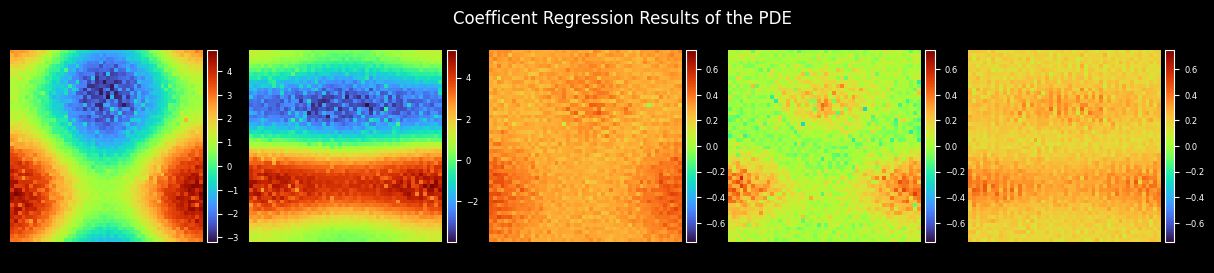

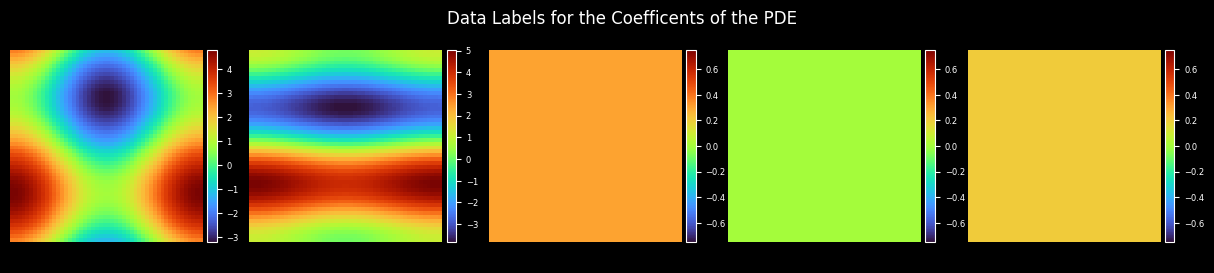

In [10]:
coe_label = get_label_coe(max_order=config["max_order"], resolution=config["mesh_size"])
coes_out_dir = os.path.join(config["figure_out_dir"], "coes")
plot_coe(model.coe, coes_out_dir, prefix="coe_trained", step=step, title="Coefficient Regression Results of the PDE")
plot_coe(coe_label, coes_out_dir, prefix="coe_label", title="Data Labels for the Coefficients of the PDE")

### Plot Test Error

Mindrecorder saved
sample 20, MSE Loss 0.061236363


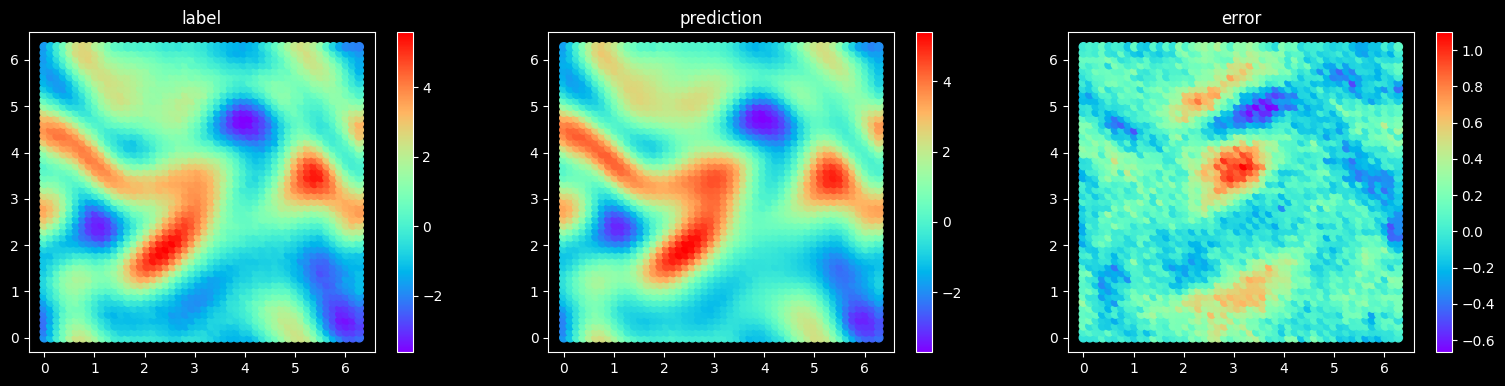

In [11]:
dataset = create_dataset(config, step, "eval.mindrecord", "test", data_size=test_data_size)
test_dataset = dataset.create_test_dataset(step)
iterator_test_dataset = test_dataset.create_dict_iterator()
final_item = [_ for _ in iterator_test_dataset][-1]
plot_test_error(model, get_loss_metric("mse"), final_item, step, config["mesh_size"], config["figure_out_dir"])

### Plot Extrapolation Error

Mindrecorder saved
step = 1, p25 = 0.06405, p75 = 0.08643
step = 2, p25 = 0.05012, p75 = 0.08393
step = 3, p25 = 0.06112, p75 = 0.10304
step = 4, p25 = 0.06977, p75 = 0.11740
step = 5, p25 = 0.07448, p75 = 0.12558
step = 6, p25 = 0.07964, p75 = 0.13329
step = 7, p25 = 0.08389, p75 = 0.14144
step = 8, p25 = 0.08721, p75 = 0.14411
step = 9, p25 = 0.08933, p75 = 0.14618
step = 10, p25 = 0.09413, p75 = 0.14660
step = 11, p25 = 0.09456, p75 = 0.14647
step = 12, p25 = 0.09532, p75 = 0.15166
step = 13, p25 = 0.09663, p75 = 0.15069
step = 14, p25 = 0.10087, p75 = 0.14878
step = 15, p25 = 0.10134, p75 = 0.14877
step = 16, p25 = 0.10700, p75 = 0.14848
step = 17, p25 = 0.10862, p75 = 0.15084
step = 18, p25 = 0.11188, p75 = 0.15105
step = 19, p25 = 0.11380, p75 = 0.15106
step = 20, p25 = 0.11437, p75 = 0.15068
step = 21, p25 = 0.11436, p75 = 0.15261
step = 22, p25 = 0.11572, p75 = 0.15087
step = 23, p25 = 0.11534, p75 = 0.15267
step = 24, p25 = 0.11588, p75 = 0.15540
step = 25, p25 = 0.11642, p75 

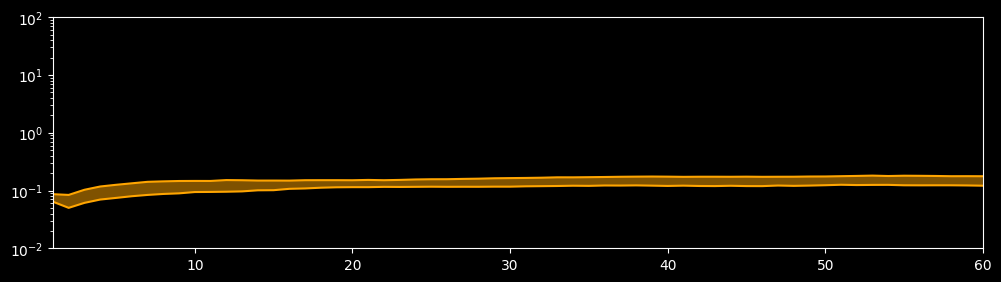

In [12]:
max_step = 60
sample_size = 40

dataset = create_dataset(config, max_step, "extrapolation.mindrecord", "test", data_size=sample_size)
plot_extrapolation_error(config, dataset, max_step=max_step)